<div style="float: right; width: 200%;">
<p style="margin: 0; padding-top: 20px; text-align:right;color:rgb(193, 38, 184)"><strong>Axity - AT&T.
    Ciclo de vida de elementos de inventario</strong></p>
</div>

# Exploratory Data Analysis

## Descripción

Analizaremos los datos del gestor SOEM con un tratamiento estadístico descriptivo para hacer el tracking del ciclo de vida de los elementos de red. 

Se creará un EDA enfocado a las tres fuentes proporcionadas por SOEM, las cuales están identificadas como **hw**, **ne** y **sw**. 

Serán documentados los catálogos propuestos junto a su respectivo tratamiento de datos. 

Primero cargamos las librerías necesarias.

#### Conectando al Datalake

In [2]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext

In [3]:
conf = SparkConf().setAppName('EDA_SOEM')  \
    .setMaster('yarn').set("spark.yarn.queue","root.eda")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re
import pandasql

from pyspark.sql.functions import udf ,col
from pyspark.sql.types import IntegerType,StringType

%matplotlib inline

from bokeh.io import show, output_notebook, output_file 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20_11, Category20c_9, Category10_5,Category10_6, Category20_20, Plasma256
output_notebook()

Loading BokehJS ...

### Recolección de los datos: 

Para analizar el gestor SOEM en conjunto, se realiza una unión de las fuentes (hw, ne y sw) para trabajar con el universo completo de SOEM.

La tabla que se utiliza como fuente es ```tx_soem_hw``` ya que aquí encontramos el número de serie, el cual utilizaremos para rastrear el ciclo de vida del elemento.

Los campos por los cuales se unen son los siguientes: ```tx_soem_hw.ne_id = tx_soem_ne.id```  y ```tx_soem_sw.hw_module_id = tx_soem_hw.id ```


Los datos con los que se trabajan a lo largo del EDA corresponden a la partición de **20191031** de las tablas ```default.tx_soem_hw```, ```default.tx_soem_ne``` y ```default.tx_soem_sw```.

*IMPORTANTE*: Si se requieren ver datos de otro periódo, se debe cambiar los filtros ```year = <año-a-ejecutar>```, ```month = <mes-a-ejecutar>```, ```day = <día-a-ejecutar>``` de las tablas en la siguiente celda:

In [111]:
df_location = spark.sql("SELECT * FROM inventario.raw_panda_location").toPandas()

In [69]:
df_load = spark.sql("SELECT a.id as id_hw, a.serialnumber as serie, a.ne_id as ne_id, b.address, b.nename as ne_name, b.location as location_id, c.typeofswunit, c.swproductnumber FROM tx_soem_hw a LEFT JOIN tx_soem_ne b on trim(a.ne_id) = trim(b.id) LEFT JOIN tx_soem_sw c on trim(c.hw_module_id) = trim(a.id) WHERE a.year = 2019 and a.month = 10 and a.day = 31 and b.year = 2019 and b.month = 10 and b.day = 31 and c.year = 2019 and c.month = 10 and c.day = 31").cache()

Creamos una funcion para el tratamiento de datos en spark el cual contiene la reglas proporcionadas por la tabla ```inventario.cat_regex_cleanup``` para la columna serie:

In [71]:
def validate_rule(string):
    
    search_list=[" ",'!','%','$',"<",">","^",'¡',"+","N/A",u'¿','~','#','Ñ',"Ã","Åƒ","Ã‹","Ã³",'Ë','*','?',"ILEGIBLE", "VICIBLE","VISIBLE","INCOMPLETO"]
    str_temp = string.encode('utf-8')
    if str_temp.upper() == "BORRADO":
      return 1
    elif len(str_temp) < 6:
      return 1
    elif any(ext in str_temp.upper()for ext in search_list):
      return 1
    else:
      return 0

Se crea un udf en spark sobre la funcion ya creada.

In [72]:
validate_rule_udf = udf(validate_rule, IntegerType())

Se le agrega una nueva columna al dataframe de spark; la nueva columna es la validacion de la columna serie con respecto al udf que creamos.

In [73]:
df_serie = df_load.withColumn("serie_cleaned",validate_rule_udf(col("serie"))).cache()

Se convierte el dataframe de spark a un dataframe de pandas.

In [74]:
df = df_serie.toPandas()

Hemos recolectado los campos a analizar de las fuentes *hw* y *ne* correspondientes a SOEM.

Muestra de los datos recolectados:

In [59]:
df.head()

,id_hw,serie,ne_id,address,ne_name,location_id,typeofswunit,swproductnumber,serie_cleaned
0,16796_1_B,TY12747513,16796,10.245.150.70,MXSLPSLP1516MW03,SANTA ROSA,AMM 6p D,CXP9010021_1,0
1,16838_1/7_N,A23108DNHX,16838,10.245.178.83,MXGROCHB0071MW07,ALQUITRAN,NPU3 C,CXP 901 2516/5,0
2,16846_1/3_M,A23105LLJW,16846,10.245.148.80,MXQTOMQS1324MW02,AEROPUERTO QUERETARO,MMU2 H,CXP 901 1133/6,0
3,17066_1030_1.1,CR9N285902,17066,10.245.248.20,MORCVA0193,CUERNAVACA,network release,CXP9026371_3_R12B51_2-11.def,0
4,16734_1/8_E,A23109EXPR,16734,10.245.145.199,MXGUASIL0500MW01,ADUANA [LA ESPERANZA],ETU3,CXCR 102 051/1,0


### Diccionario de datos

A continuación se enlistan los campos de la fuente con una breve descripción de negocio.  

Fuente HW:

* **nodename**: nombre del nodo o fuente
* **id**: id único del registro
* **ammposition**: por definir
* **assetid**: por definir
* **typeofunit**: por definir
* **productnumber**: número del producto
* **version**: por definir
* **serialnumber**: número de serie
* **productiondate**: por definir
* **elapsedruntime**: por definir
* **ne_id**: id que se utiliza para hacer la unión con SOEM ne
* **nealias**: por definir
* **notes**: por definir
* **updatedate**: por definir
* **moduleproductnumber**: por definir
* **moduleserialnumber**: por definir
* **filedate**: Fecha de carga del archivo.
* **filename**: Nombre del archivo cargado.
* **hash_id**: Identificador único Hash.
* **source_id**: Fuente de archivo.
* **registry_state**: Timestamp de carga.
* **datasetname**: Nombre del ....
* **timestamp**: Fecha de carga.
* **transaction_status**: Estatus de carga.
* **year**: Año del archivo.
* **month**: Mes del archivo.
* **day**: Día del archivo.

Fuente NE:

* **nodename**: nombre del nodo o fuente
* **id**: id único del registro
* **type**: por definir
* **address**: por definir
* **nename**: por definir
* **location**: código de ubicación
* **information**: por definir
* **site_id**: número de serie
* **nealias**: por definir
* **nenotes**: por definir
* **updatedate**: por definir
* **neaddedtime**: por definir
* **nelastmanagedtime**: por definir
* **nelaststartedtime**: por definir
* **nelastmodifiedtime**: por definir
* **filedate**: Fecha de carga del archivo.
* **filename**: Nombre del archivo cargado.
* **hash_id**: Identificador único Hash.
* **source_id**: Fuente de archivo.
* **registry_state**: Timestamp de carga.
* **datasetname**: Nombre del ....
* **timestamp**: Fecha de carga.
* **transaction_status**: Estatus de carga.
* **year**: Año del archivo.
* **month**: Mes del archivo.
* **day**: Día del archivo.

Fuente SW:

* **nodename**: nombre del nodo o fuente
* **id**: id único del registro
* **minimumswversion**: por definir
* **typeofswunit**: por definir
* **swproductnumber**: por definir
* **activesw**: por definir
* **passivesw**: por definir
* **hw_module_id**: id único para unir con hw
* **nealias**: por definir
* **updatedate**: por definir

### 2. Descripción de las fuentes
En este apartado se hará una descripción a detalle de el dataframe para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [33]:
campos=df.columns
print('Columnas de la fuente SOEM son: ',list(campos))
pd.DataFrame(df.dtypes,columns=['Tipo de objeto SOEM'])

('Columnas de la fuente SOEM son: ', ['id_hw', 'serie', 'ne_id', 'address', 'ne_name', 'location_id', 'typeofswunit', 'swproductnumber', 'serie_cleaned'])


,Tipo de objeto SOEM
id_hw,object
serie,object
ne_id,object
address,object
ne_name,object
location_id,object
typeofswunit,object
swproductnumber,object
serie_cleaned,int32


In [34]:
print('renglones = ',df.shape[0],' columnas = ',df.shape[1])

('renglones = ', 1318, ' columnas = ', 9)


In [80]:
df.describe(include='all')

,id_hw,serie,ne_id,address,ne_name,location_id,typeofswunit,swproductnumber,serie_cleaned
count,1318,1286,1318,1318,1318,1318,1318,1286,1318.000000
unique,1318,1250,192,192,187,134,20,13,NaN
top,17032_1/3.1_R,CR9N280625,5664,10.245.225.2,MXHID9002MW05,TEXCOCO,MMU2 H,CXP 901 2878,NaN
freq,1,2,18,18,18,54,328,371,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000759
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027545
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


De la tabla podemos observar que el total de elementos que existen para la fuente son *1,318* registros.

* **números de serie únicos**: 1,251
* **números de serie duplicados**: 67

#### Se proponen catálogos derivados de la fuente SOEM con los siguientes campos:
    
* **ne_name**: Código del sitio.
* **location_id**: Identificador del sitio.  

Estos catálogos nos ayudarán a complementar el catálogo ```inventario.raw_panda_location``` y a homologar los nombres y códigos que se tienen de los sitios y location.


### 3. Exploración de los datos.
De acuerdo al análisis anterior, procedemos a hacer una exploración de los datos con gráficas.

#### Para empezar, se hará una limpieza general a los datos:

In [76]:
df.replace('null',np.NaN,inplace=True)
df.replace('NA',np.NaN,inplace=True)
df.replace('UNKNOWN',np.NaN,inplace=True)

### Catálogo Location

Empezaremos con el catálogo de **location_id**. Se hará una revisión de frecuencias de datos y se mostrará en  diferentes tipos de gráficas para su visualización. Este catálogo será llamado después en el apartado de catálogos, nuestra intención por el momento es simplemente explorar los datos.

In [ ]:
location_id=pd.DataFrame(df.location_id.value_counts()[:10])

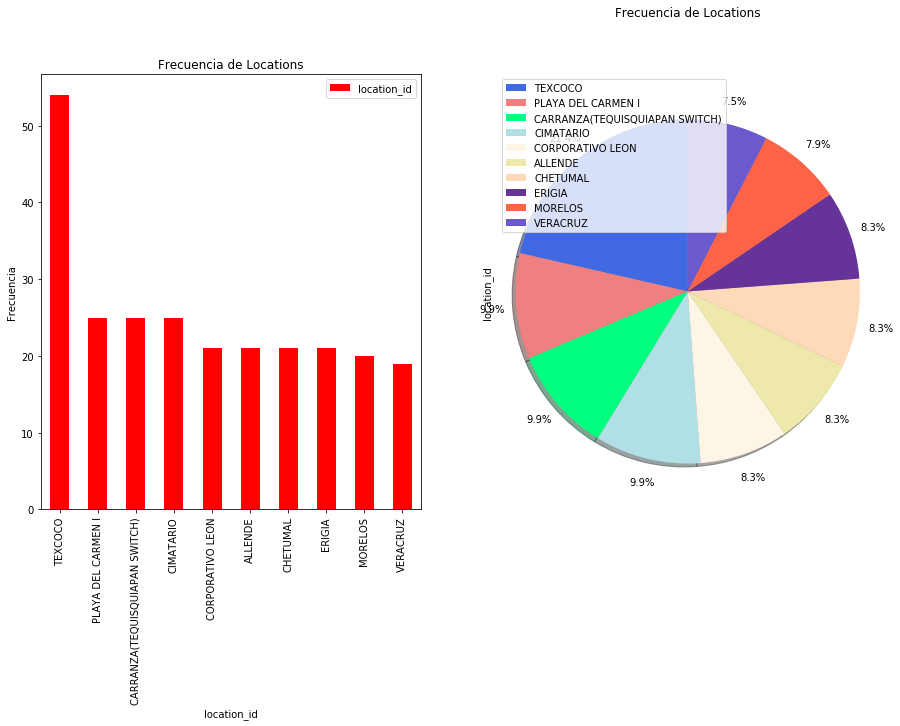

In [40]:
#Revisamos frecuencias:
location=pd.DataFrame(df.location_id.value_counts()[:10])

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
location.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'location_id')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Frecuencia de Locations')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
explode_list=[0,0,0,0,0,0,0,0,0,0] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue']

location['location_id'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Frecuencia de Locations',y=1.12)
ax1.axis('equal')
ax1.legend(labels=location.index,loc='upper left')

plt.show()

Podemos observar que el locatio con mas frecuencia es Texcoco con un **21.4%** de frecuencia en la fuente.

#### Visualización de los datos de trazabilidad: 

In [81]:
pd.DataFrame(df.serie.value_counts()[:15])

,serie
CR9N280625,2
CR9N285918,2
CR9M954394,2
CR9M935934,2
CR9P377329,2
CR9K968705,2
CR9N280632,2
CR9N026545,2
CR9N157637,2
CR9L847073,2


#### Es de interés haber observado los datos que se usaran para la trazabilidad, NOTAS OBSERVABLES. 
* Activo: no hay en la fuente de SOEM un campo activo.
* Serie: existen números de serie duplicados y vacíos.

### 4. Calidad de los datos
Se documentará la calidad de los datos y analizará las variables que necesitan tratamiento con la ayuda de visualizaciones y tablas.

### Missings Values
Los missings values son los valores faltantes en el conjunto de datos que se refieren a aquellos campos que están vacíos o no tienen valores asignados, estos generalmente ocurren debido a errores de entrada de datos, fallas que ocurren con los procesos de recopilación de datos y, a menudo, al unir varias columnas de diferentes tablas encontramos una condición que conduce a valores faltantes. Existen numerosas formas de tratar los valores perdidos, los más fáciles son reemplazar el valor perdido con la media, la mediana, la moda o un valor constante (llegamos a un valor basado en el conocimiento del dominio) y otra alternativa es eliminar la entrada desde el conjunto de datos en sí.

Calculamos el porcentaje de NA's que tiene la fuente por columna y el porcentaje de los missings.

In [84]:
nas=df.isna().sum()
porcentaje_nas=nas/df.isna().count()

columnas=list(porcentaje_nas.keys())
counts_nas=list(porcentaje_nas.values)

#Para el siguiente comando, en el parámetro "color":
#Dependiendo el número de columnas se escoge un pallete, este debe ser cargado en la sección de librerías,
#Sólo se añade a la parte from bokeh.palettes import Category20c_20  colocando una ","
#http://docs.bokeh.org/en/1.3.2/docs/reference/palettes.html
#Se recomienda no poner más de 20 columnas. 
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_9))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

,Porcentaje de NAs
id_hw,0.000000
serie,2.427921
ne_id,0.000000
address,0.000000
ne_name,0.000000
location_id,0.000000
typeofswunit,0.000000
swproductnumber,2.427921
serie_cleaned,0.000000


#### Visualización de datos NOT NULL: 

In [86]:
notmiss=(1-porcentaje_nas)*100

columnas=list(notmiss.keys())
counts_nas=list(notmiss.values)

#Mismo aplica aquí para color
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_9))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,100), 
         title='Porcentaje de not-nulls por columna')
p.vbar(x='columnas',top='counts_nas',width=.5, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(notmiss,columns=['Porcentaje de Not nulls'])

,Porcentaje de Not nulls
id_hw,100.000000
serie,97.572079
ne_id,100.000000
address,100.000000
ne_name,100.000000
location_id,100.000000
typeofswunit,100.000000
swproductnumber,97.572079
serie_cleaned,100.000000


El campo de serie el cual ocupamos para la trazabilidad de elementos, tiene un **2.42%** de nulos y de los cueles perdemos la trazabilidad en este gestor.

### 5. Catálogos.

#### Catálogo location_id

A continuación se muestra el catálogo limpio para los location y sus ne names.

In [115]:
Catalogo_location = pandasql.sqldf("WITH cat_ne as( SELECT CASE WHEN bandera_limpieza = 1 THEN substr(ne_name, instr(ne_name, 'MX')+2, instr(ne_name, 'MW')-3) WHEN bandera_limpieza = 2 THEN substr(ne_name, 1, instr(ne_name, '_')-1) ELSE ne_name END ne_name, location_id FROM( SELECT DISTINCT ne_name, CASE WHEN ne_name LIKE 'MX%MW%' THEN 1 WHEN ne_name LIKE '%\\_%' THEN 2 ELSE 0 END bandera_limpieza, location_id FROM df)a), cat_location as (SELECT DISTINCT latitude, longitude, location_attid FROM df_location WHERE location_attid IS NOT NULL) SELECT location_id, ne_name, latitude, longitude FROM cat_ne LEFT JOIN cat_location ON trim(ne_name) = trim(location_attid)", locals())
Catalogo_location.head()

,location_id,ne_name,latitude,longitude
0,SANTA ROSA,SLPSLP1516,22.191422,-100.999888
1,ALQUITRAN,GROCHB0071,17.395645,-99.519063
2,AEROPUERTO QUERETARO,QTOMQS1324,20.602450,-100.202870
3,CUERNAVACA,MORCVA0193,18.890000,-99.221056
4,ADUANA [LA ESPERANZA],GUASIL0500,21.008472,-101.517250


Este mismo catálogo lo podemos observar en un mapa usando las latitudes y longitudes obtenidas  del catálogo **raw_panda_invenatrio**.

In [118]:
mapa_location=Catalogo_location.loc[:,['location_id','latitude','longitude']].dropna()
mapa_location.drop_duplicates(inplace=True)

In [120]:
import folium
from folium import plugins

Latitud=21.607871
Longitud=-101.201933
mapa=folium.Map(location=[Latitud,Longitud],zoom_start=4.8)

storages = folium.map.FeatureGroup()

for lat, lng, in zip(mapa_location.latitude, mapa_location.longitude):
    storages.add_child(
        folium.features.Marker(
            [lat, lng]
        )
    )
    
latitudes = list(mapa_location.latitude)
longitudes = list(mapa_location.longitude)
labels = list(mapa_location.location_id)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(storages) 
mapa.save('Mapa de Locations en Gestor SOEM.html')
mapa.add_child(storages)

### 6. Preparación de los datos.
Para la preparación de los datos crearemos las reglas de calidad o estándares observados en el apartado anterior de acuerdo a la calidad de datos obtenidos: 

* **location_id**: quitar nomenclaturas MX y MW para obtener el código que se encuentra dentro de la cadena.
* Para todos los campos se recomienda transformarlas a mayúsculas.

### 7. Métricas KPI.
Se mostrarán los KPIs generados. 

In [92]:
Total_Elementos=df.shape[0]
Total_Elementos

1318

In [93]:
df.replace(np.NaN,'vacio',inplace=True)

#### Total Elementos Trazables Únicos

In [94]:
Total_Tr_Unic=df[['serie']].loc[(df.serie!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic

1250

#### Total de elementos duplicados

In [95]:
Total_Tr_Dupli=Total_Elementos-Total_Tr_Unic
Total_Tr_Dupli

68

De este gestor solo se pueden tomar los indicadores total de elementos, total de elementos únicos por serie y total de elementos duplicados, los otros KPI's no se pueden calcular ya que la fuente no cuenta con número de activo.

In [98]:
Total_Tr = 0
Total_NOTr = 0
Total_Tr_Unic_CS_CA = 0
Total_Tr_Unic_CS_SA = 0
Total_Tr_Unic_SS_CA = 0

In [101]:
KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Unicos',
                         'Total Duplicados',
                          'Total CS CA','Total CS SA','Total SS CA'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli,
                               Total_Tr_Unic_CS_CA,Total_Tr_Unic_CS_SA,
                              Total_Tr_Unic_SS_CA]})

KPIs

,KPI,Resultado
0,Total Elementos,1318
1,Total Elementos Trazables,0
2,Total NO Trazables,0
3,Total Unicos,1250
4,Total Duplicados,68
5,Total CS CA,0
6,Total CS SA,0
7,Total SS CA,0


In [ ]:
sc.stop()